<a href="https://colab.research.google.com/github/NataliiaHromyk/HomeWork_Python_DS/blob/main/Hromyk_%22HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nataliiahromyk
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 364MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-3/bank-customer-churn-prediction-dlu-course-c-3.zip to ./bank-customer-churn-prediction-dlu-course-c-3
F1 score: 0.64%
Accuracy: 87.42%


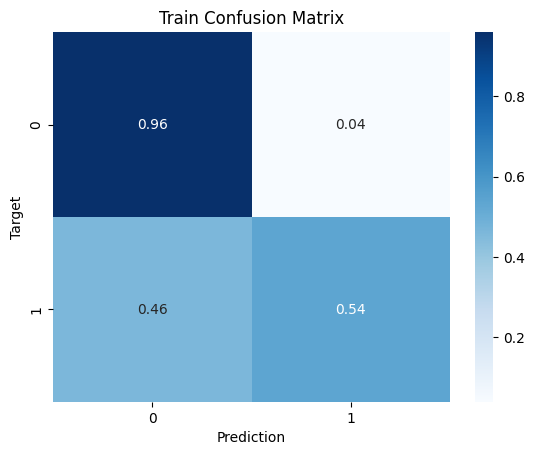

Area under ROC score on Train dataset: 0.88%


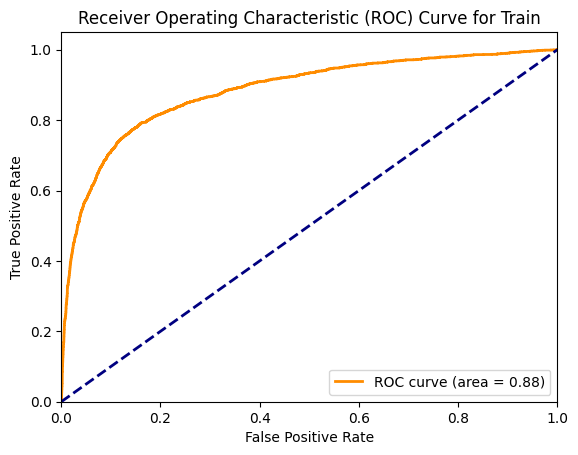

F1 score: 0.64%
Accuracy: 87.17%


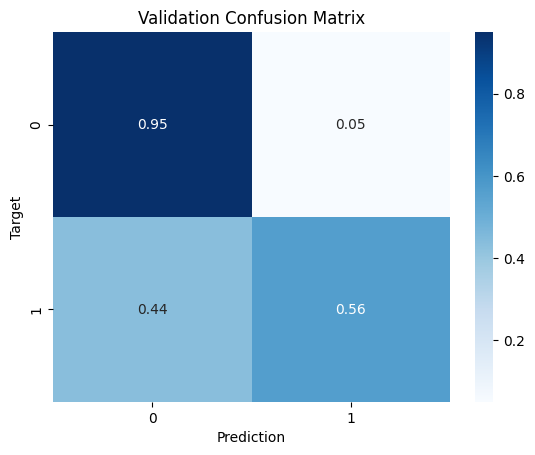

Area under ROC score on Validation dataset: 0.88%


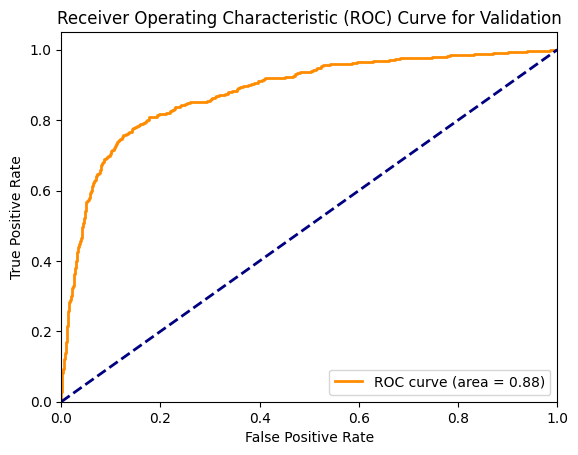

['Exited_pipeline.joblib']

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
train_csv = data_dir + '/train.csv'
train_main_df = pd.read_csv(train_csv, index_col=0)

train_df, val_df = train_test_split(train_main_df, test_size=0.2, random_state=42, stratify=train_main_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_main_df.columns)[1:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

#додаткове поле
train_inputs['Gender_Male_code'] = train_inputs.Gender.map({'Female': 0, 'Male': 1})
val_inputs['Gender_Male_code'] = val_inputs.Gender.map({'Female': 0, 'Male': 1})

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
encoded_cols_name = ['Geography']
#scaler_numeric_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
#model_columns = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','France','Germany','Spain','Gender_Male_code']

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, encoded_cols_name)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}%".format(f1))
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Predict probabilities
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'Exited_pipeline.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-3" (use force=True to force download)
F1 score: 0.70
Accuracy: 89.26


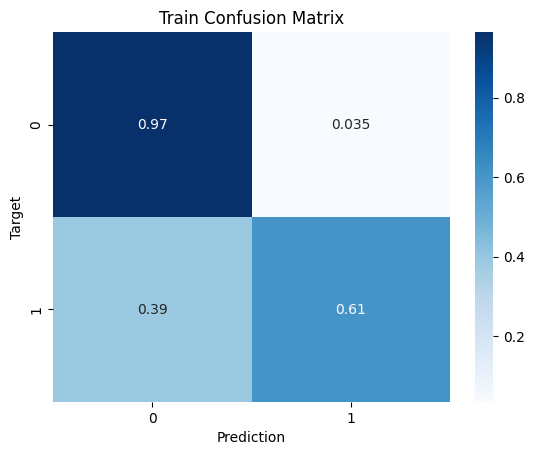

Area under ROC score on Train dataset: 0.92


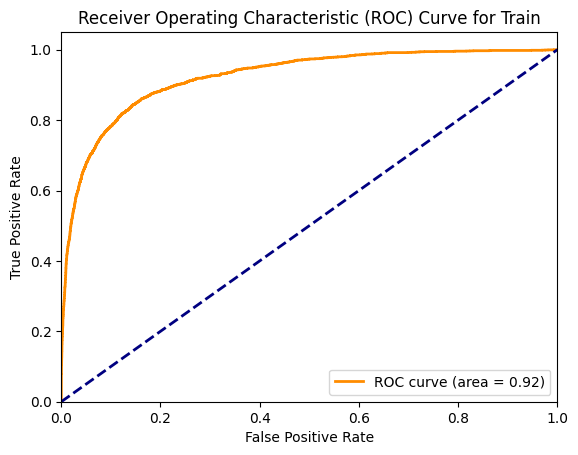

F1 score: 0.70
Accuracy: 89.13


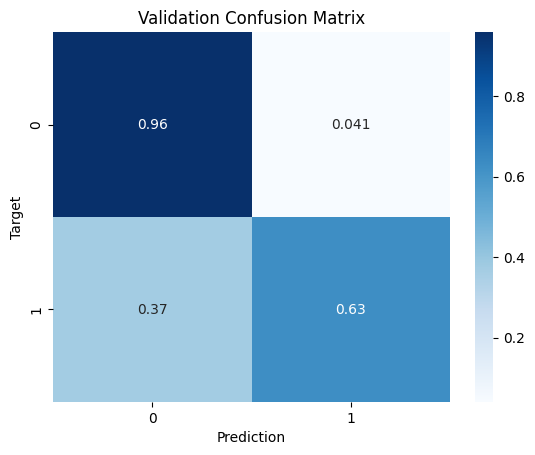

Area under ROC score on Validation dataset: 0.92


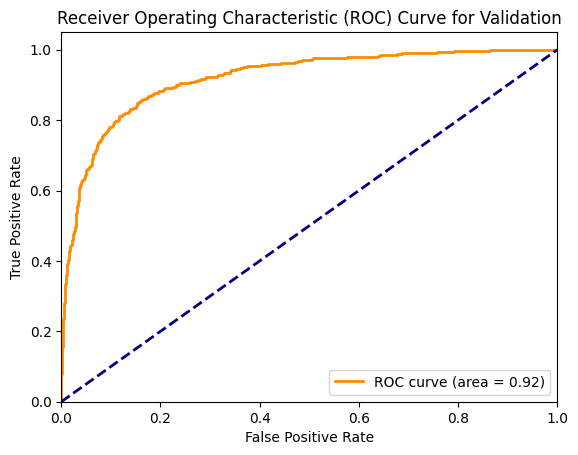

['Exited_pipeline_polinom_2.joblib']

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
import pandas as pd
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
train_csv = data_dir + '/train.csv'
train_main_df = pd.read_csv(train_csv, index_col=0)

train_df, val_df = train_test_split(train_main_df, test_size=0.2, random_state=42, stratify=train_main_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_main_df.columns)[1:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

#додаткове поле
train_inputs['Gender_Male_code'] = train_inputs.Gender.map({'Female': 0, 'Male': 1})
val_inputs['Gender_Male_code'] = val_inputs.Gender.map({'Female': 0, 'Male': 1})

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
encoded_cols_name = ['Geography']
#scaler_numeric_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
#model_columns = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','France','Germany','Spain','Gender_Male_code']

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, encoded_cols_name)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
degree=2
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier1', PolynomialFeatures(degree=degree)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}".format(f1))
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Predict probabilities
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'Exited_pipeline_polinom_2.joblib')

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-3" (use force=True to force download)
F1 score: 0.75
Accuracy: 90.54


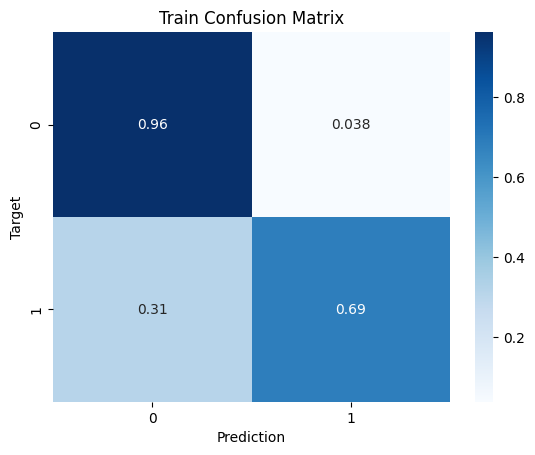

Area under ROC score on Train dataset: 0.94


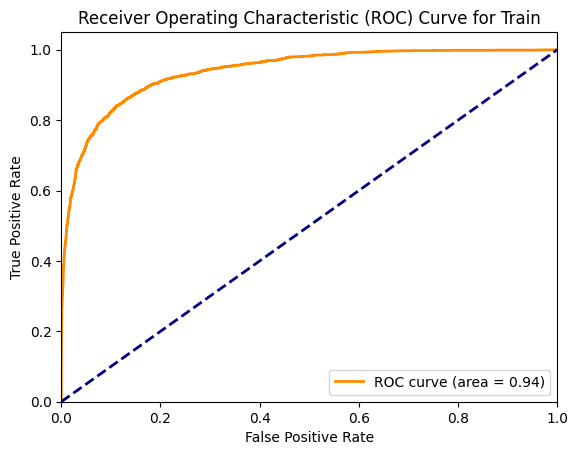

F1 score: 0.72
Accuracy: 89.40


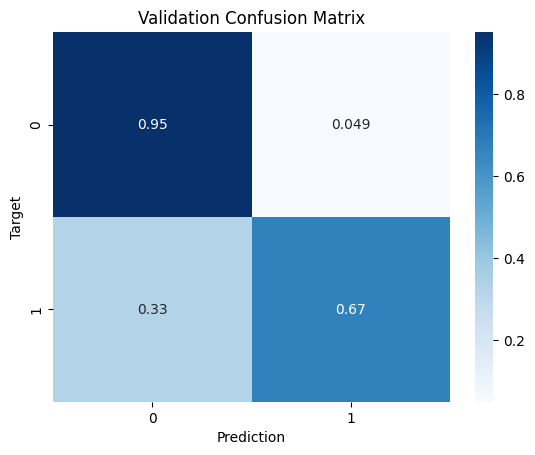

Area under ROC score on Validation dataset: 0.93


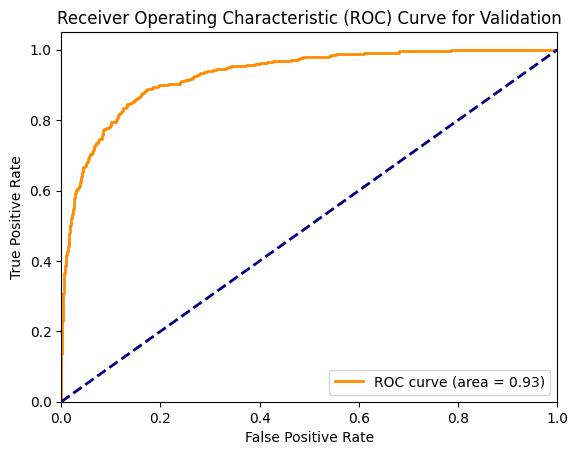

['Exited_pipeline_polinom_4.joblib']

In [145]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import os
import pandas as pd
import operator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
train_csv = data_dir + '/train.csv'
train_main_df = pd.read_csv(train_csv, index_col=0)

train_df, val_df = train_test_split(train_main_df, test_size=0.2, random_state=42, stratify=train_main_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_main_df.columns)[1:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

#додаткове поле
train_inputs['Gender_Male_code'] = train_inputs.Gender.map({'Female': 0, 'Male': 1})
val_inputs['Gender_Male_code'] = val_inputs.Gender.map({'Female': 0, 'Male': 1})

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
encoded_cols_name = ['Geography']
#scaler_numeric_cols = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
#model_columns = ['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary','France','Germany','Spain','Gender_Male_code']

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, encoded_cols_name)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
degree=4
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier1', PolynomialFeatures(degree=degree)),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}".format(f1))
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    # Predict probabilities
    y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()
    return preds

def predict_raw_df(input_df):
    input_df['Gender_Male_code'] = input_df.Gender.map({'Female': 0, 'Male': 1})
    preds_proba = model_pipeline.predict_proba(input_df)
    return preds_proba

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'Exited_pipeline_polinom_4.joblib')

Найкращы показники логістичної моделі з поліноміальними ознаками у 4 степені, саме тому дані з цієї моделі звантажемо у кагл змагання

In [139]:
test_csv = data_dir + '/test.csv'
test_raw_df = pd.read_csv(test_csv)
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [150]:
subm_pred = predict_raw_df(test_raw_df)[:,1]
subm_pred

array([0.11858184, 0.02135151, 0.06258291, ..., 0.00888797, 0.10698578,
       0.08896272])

In [154]:
sample_submission_csv = data_dir + '/sample_submission.csv'
sample_submission_df = pd.read_csv(sample_submission_csv)
sample_submission_df['Exited'] = subm_pred
sample_submission_df

,id,Exited
0,15000,0.118582
1,15001,0.021352
2,15002,0.062583
3,15003,0.388924
4,15004,0.025430
...,...,...
9995,24995,0.011712
9996,24996,0.009487
9997,24997,0.008888
9998,24998,0.106986


In [155]:
sample_submission_df.to_csv("submission_log_reg.csv", index=False)

In [156]:
from google.colab import files
files.download("submission_log_reg.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [8]:
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/ML_files

In [5]:
regression_data_df = pd.read_csv("drive/MyDrive/ML_files/regression_data.csv")
regression_data_df

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013
...,...,...,...,...,...,...
124,1.402794,0.586857,-1.401851,0.791032,-0.909387,39.626185
125,-0.288659,-0.827231,0.322719,-1.002529,-0.018513,-50.585687
126,-1.407464,-0.213447,-0.718444,0.232050,-1.448084,13.719861
127,1.353872,1.237816,-0.114540,-0.469176,-1.713135,-23.851350


In [64]:
X_train, X_val, y_train, y_val = train_test_split(regression_data_df[list(regression_data_df.columns)[1:-1]], regression_data_df['target'], test_size=0.2, random_state=42)

In [65]:
X_train

,feature_2,feature_3,feature_4,feature_5
70,0.628346,0.624120,-1.214189,1.158111
78,1.119575,3.078881,-0.249036,0.576557
47,1.201214,-0.326024,0.289775,2.075401
0,-1.382800,-0.875618,0.538910,-1.037246
12,0.404982,1.765454,-0.334501,-0.474945
...,...,...,...,...
106,0.645376,0.971571,2.060748,1.755341
14,-0.161286,-0.802277,-1.415371,-0.420645
92,0.173181,-1.245739,-0.446515,0.856399
51,0.081874,-0.485364,0.758969,-0.772825


In [9]:
np.mean(regression_data_df['target']), np.std(regression_data_df['target'])

(np.float64(-3.9029835552255245), 45.29005128480081)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print('Train RMSE: ', mean_squared_error(y_train, y_pred_train)**0.5)
print('Test RMSE: ', mean_squared_error(y_val, y_pred_val)**0.5)

Train RMSE:  1.0765060688636838
Test RMSE:  0.850348108781724


In [12]:
y_pred_model = model.predict(regression_data_df[list(regression_data_df.columns)[1:-1]])

In [13]:
def normal_equations(X,y):
    """Computes the closed-form solution to linear regression"""
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta

In [14]:
MNK_coefs = normal_equations(X_train, y_train)
predictions_MNK = np.dot(X_val, MNK_coefs)

r2 = r2_score(y_val, predictions_MNK)

print(f"R² score: {r2:.20f}")

R² score: 0.99967911526952846213


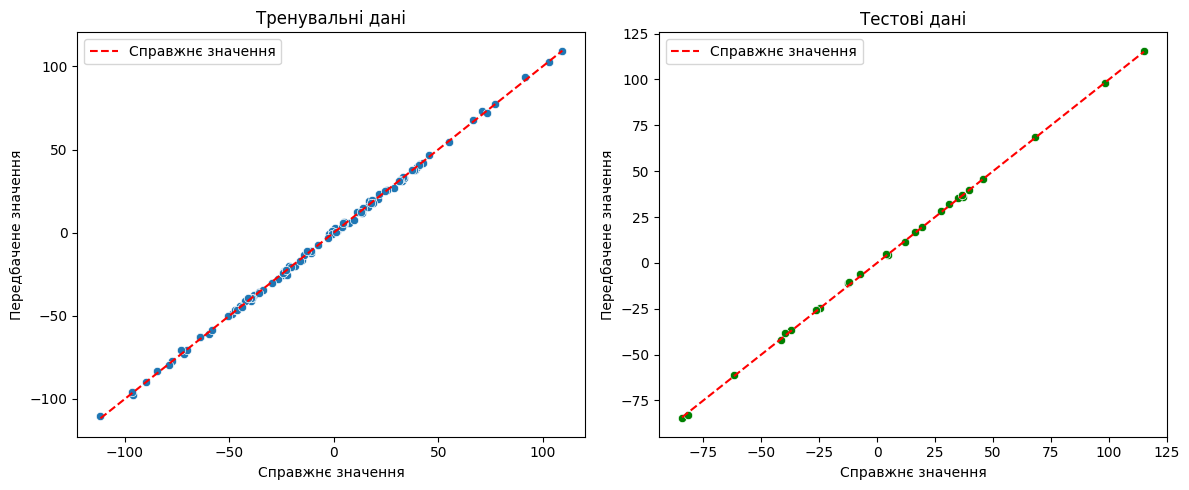

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Для тренувальної вибірки
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_pred_train)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Справжнє значення')  # ідеальна лінія
plt.xlabel("Справжнє значення")
plt.ylabel("Передбачене значення")
plt.title("Тренувальні дані")
plt.legend()

# Для тестової вибірки
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val, y=y_pred_val, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Справжнє значення')
plt.xlabel("Справжнє значення")
plt.ylabel("Передбачене значення")
plt.title("Тестові дані")

plt.tight_layout()
plt.legend()
plt.show()


Дані буквально являються лінійними і передбачення майже 100%

поліноміальними ознаками до степені 5 включно

In [16]:
import operator
from sklearn.preprocessing import PolynomialFeatures

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Функція градієнтного спуску
def gradient_descent(X_train, y_train, X_val, y_val, learning_rate, n_iterations):
    m = len(y_train)
    theta = np.random.randn(X_train.shape[1], 1)
    learning_curve_train = []
    learning_curve_val = []

    for iteration in range(n_iterations):
        gradients = 2/m * X_train.T.dot(X_train.dot(theta) - y_train)
        theta = theta - learning_rate * gradients

        y_pred = X_train.dot(theta)
        y_pred_val = X_val.dot(theta)

        # Виправлення: реверс до 1D
        train_error = mean_squared_error(y_train.ravel(), y_pred.ravel())**0.5
        val_error = mean_squared_error(y_val.ravel(), y_pred_val.ravel())**0.5

        learning_curve_train.append(train_error)
        learning_curve_val.append(val_error)

    print('Train RMSE: ', train_error)
    print('Val RMSE: ', val_error)
    return theta, learning_curve_train, learning_curve_val


# Побудова графіка навчання
def plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val):
    plt.plot(range(n_iterations), learning_curve_train, 'r-', label='Training error')
    plt.plot(range(n_iterations), learning_curve_val, 'g-', label='Validation error')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.title('Learning Curve (Gradient Descent)')
    plt.legend()
    plt.grid()
    plt.show()


# Побудова моделі
def plot_model(theta, X_train, y_train, X_val, y_val):
    plt.scatter(X_train[:, 1], y_train, color='blue', label='Train Data')
    plt.scatter(X_val[:, 1], y_val, color='orange', label='Val Data')

    # Комбінування та сортування
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)
    sort_idx = np.argsort(X_combined[:, 1])
    X_sorted = X_combined[sort_idx]
    y_pred_sorted = X_sorted.dot(theta)

    plt.plot(X_sorted[:, 1], y_pred_sorted, color='red', label='Model')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Polynomial Regression Fit')
    plt.legend()
    plt.grid()
    plt.show()


# Основна функція
def fit_poly_reg(X_train_df, y_train, X_val_df, y_val, degree, learning_rate, n_iterations):
    # Трансформація поліноміальних ознак
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_df)
    X_val_poly = poly.transform(X_val_df)

    # Перетворення y у вектор-стовпчик
    y_train = y_train.values.reshape(-1, 1)
    y_val = y_val.values.reshape(-1, 1)

    # Навчання
    theta, learning_curve_train, learning_curve_val = gradient_descent(
        X_train_poly, y_train, X_val_poly, y_val, learning_rate, n_iterations
    )

    # Графік
    plot_learning_curve(n_iterations, learning_curve_train, learning_curve_val)

    return X_train_poly, X_val_poly, theta

Train RMSE:  3.8037864454571195e+24
Val RMSE:  4.3522307857338917e+23


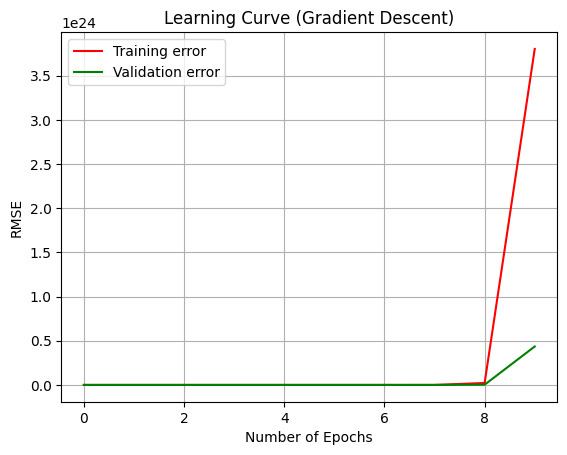

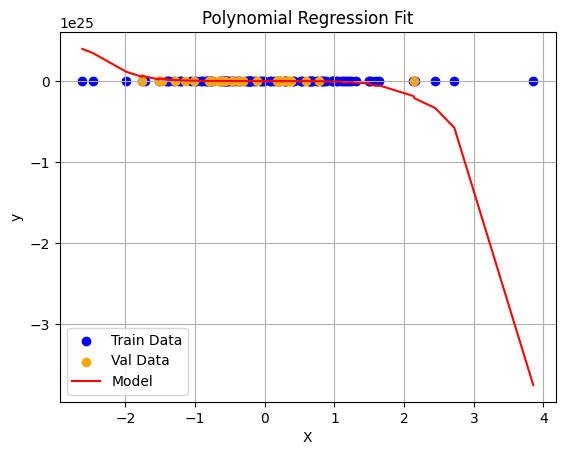

In [118]:
X_train_poly, X_val_poly, theta = fit_poly_reg(
    X_train, y_train, X_val, y_val,
    degree=5,
    learning_rate=0.01,
    n_iterations=10
)
plot_model(theta, X_train_poly, y_train, X_val_poly, y_val)

In [112]:
np.mean(regression_data_df['target']), np.std(regression_data_df['target'])

(np.float64(-3.9029835552255245), 45.29005128480081)

Порівнюючи рмсе та стандартне відхилення - можна зробити висновок, що модель гуд. Але як бачимо в мінімальних та максимальних значення крива йде в різні сторони. А поглянувши на показники лінійної регресії - помітні дуже високі показники якості моделі. Це говорить про те, що ліпше використовувати лінійну регресію на даних

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [119]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [120]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = (mean_squared_error(y_train, y_train_pred)**0.5)
    val_metrics = (mean_squared_error(y_val, y_val_pred)**0.5)

    return dict(train=train_metrics, val=val_metrics)

In [125]:
poly_features = PolynomialFeatures(degree=10)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.transform(X_val)

In [126]:
X_train_poly.shape

(103, 1001)

In [128]:
import warnings

warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_val_poly, y_val)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 1.2239155579270877e-10, 'val': 808.0065259831306}

Ridge(): {'train': 1.3902092906015409, 'val': 809.1879471350127}

Ridge(alpha=2): {'train': 2.0977730311613647, 'val': 687.7290458954814}

Lasso(): {'train': 2.1095735088716654, 'val': 3.714873835231174}

ElasticNet(): {'train': 11.212550118292077, 'val': 247.64234752289752}

ElasticNet(alpha=0.5): {'train': 8.677596417108253, 'val': 178.90659405757344}



З поліномом в 10 степені регресія Lasso спрацювала найліпше, маючи найнижчий показник рмсе на тестувальнрих та валідаційних даних

In [129]:
model = Lasso()
model.fit(X_train_poly, y_train)

coefs_df = pd.DataFrame(poly_features.get_feature_names_out(X_train.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()

In [130]:
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).style.background_gradient()

,value
feature_name,
feature_4,45.146800
feature_4^5,0.827990
feature_2^4 feature_4,0.077810
feature_4 feature_5^8,0.038220
feature_2^6 feature_3^2 feature_4,0.021830
feature_2^6 feature_4,0.009740
feature_2^2 feature_3^7 feature_4,0.008340
feature_4^9 feature_5,0.007290
feature_2 feature_5^9,0.006220


Бачимо, що найсильніший вплив має feature_4
